## 1. Dataset Understanding
The first phase of any data-centric project, particularly in the healthcare domain, requires a thorough understanding of the structure, semantics, and scope of the data sources involved. This notebook is dedicated to the initial exploration of the MIMIC-III clinical database, a publicly available dataset that includes de-identified health-related data associated with over 60,000 intensive care unit (ICU) admissions. The database encompasses a wide range of structured tables capturing demographic information, administrative details, diagnoses, laboratory results, vital signs, prescriptions, and more.
The primary goal of this chapter is to provide a systematic overview of the core MIMIC-III tables that are fundamental to our modeling task. By performing an initial inspection of each dataset—examining their dimensionality, column names, data types, and representative records—we establish a foundational understanding that will inform downstream preprocessing, cohort definition, and feature engineering strategies.

To preserve computational feasibility during initial exploration, only a sample of rows is loaded for the largest tables. Full data ingestion will be deferred to the feature engineering phase, where filters based on cohort definitions and ICU stay windows will be applied.
This initial exploration enables a critical appraisal of data completeness, granularity, and linkage keys across tables, and lays the groundwork for selecting an appropriate disease cohort and engineering predictive variables for ICU length of stay modeling.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [23]:
PATH='../data/raw/'

patients = pd.read_csv(PATH + "PATIENTS.csv")
admissions = pd.read_csv(PATH + "ADMISSIONS.csv")
icustays = pd.read_csv(PATH + "ICUSTAYS.csv")
diagnoses = pd.read_csv(PATH + "DIAGNOSES_ICD.csv")
d_icd_diagnoses = pd.read_csv(PATH + "D_ICD_DIAGNOSES.csv")
chartevents = pd.read_csv(PATH + "CHARTEVENTS.csv", nrows=100)
labevents = pd.read_csv(PATH + "LABEVENTS.csv", nrows=5000)
inputevents_mv = pd.read_csv(PATH + "INPUTEVENTS_MV.csv", nrows=5000)
inputevents_cv = pd.read_csv(PATH + "INPUTEVENTS_CV.csv", nrows=5000)
outputevents = pd.read_csv(PATH + "OUTPUTEVENTS.csv", nrows=5000)
prescriptions = pd.read_csv(PATH + 'PRESCRIPTIONS.csv', usecols=['HADM_ID', 'DRUG'])

## 1.1 Demographic and Mortality Data of Patients
PATIENTS.csv provides demographic and survival information for each patient included in the MIMIC-III database.
This dataset is essential for identifying individual patients and for understanding general demographic patterns, such as gender distribution, age-related trends, and mortality rates.
The file allows the integration of demographic information with clinical and physiological data, enabling a comprehensive assessment of patient characteristics and long-term outcomes after critical care.

In [5]:
print(patients.shape)
display(patients.head())

(46520, 8)


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


## 1.2 Hospital Admission History and Patient Care Pathways
ADMISSIONS.csv documents each hospitalization event of patients registered in the MIMIC-III database. This dataset is critical for tracking the history of care, analyzing admission patterns, and studying the causes of hospitalization and clinical outcomes of critically ill patients. The table provides a comprehensive view of the patient pathway within the health care facility, allowing analyses on the impact of length of stay, frequency of hospitalizations, and key diagnostics associated with admission. It also allows linking different clinical episodes of the same patient, facilitating longitudinal studies.

In [6]:
print(admissions.shape)
display(admissions.head())

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


## 1.3 ICU Stay Records and Critical Care Timeline
ICUSTAYS.csv describes all Intensive Care Unit (ICU) stays within a hospitalization event for each patient. It provides granular information on ICU admission and discharge times, type of care unit, and length of stay in ICU (LOS), which represents the primary target variable of this project. The dataset plays a central role in predicting patient outcomes and understanding care delivery within the ICU environment. The data can be linked with other clinical data sources to extract temporal trends and treatment patterns during the ICU stay.

In [7]:
print(icustays.shape)
display(icustays.head())

(61532, 12)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


## 1.4 Diagnosis Codes and Clinical Conditions Assigned During Admissions

DIAGNOSES_ICD.csv lists the diagnostic codes (ICD-9) assigned to each hospital admission, defining the clinical conditions for each patient encounter. D_ICD_DIAGNOSES.csv provides detailed descriptions of ICD-9 codes, offering the clinical context for each diagnosis. Together, these datasets are fundamental for identifying patient cohorts based on specific diseases, which is the starting point of the project pipeline. They enable comprehensive studies of comorbidity profiles and disease-specific clinical pathways of ICU patients.

In [9]:
print(diagnoses.shape)
display(diagnoses.head())

(651047, 5)


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [10]:
print(d_icd_diagnoses.shape)
display(d_icd_diagnoses.head())

(14567, 4)


,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


## 1.5 Continuous Monitoring of Physiological and Clinical Parameters in ICU

CHARTEVENTS.csv records bedside clinical observations and vital signs collected continuously during ICU stays. This is the largest dataset in MIMIC-III and contains high-resolution data on physiological measurements (e.g., heart rate, blood pressure, respiratory rate). It provides crucial insights into the acute clinical state of patients and allows for detailed time-series analysis to model patient deterioration or recovery trends. Due to its large size, it may be useful to sample it for exploratory data analysis.

In [11]:
print(chartevents.shape)
display(chartevents.head())

(100, 15)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,788,36,165660,241249,223834,2134-05-12 12:00:00,2134-05-12 13:56:00,17525,15.00,15.00,L/min,0,0,NaN,NaN
1,789,36,165660,241249,223835,2134-05-12 12:00:00,2134-05-12 13:56:00,17525,100.00,100.00,NaN,0,0,NaN,NaN
2,790,36,165660,241249,224328,2134-05-12 12:00:00,2134-05-12 12:18:00,20823,0.37,0.37,NaN,0,0,NaN,NaN
3,791,36,165660,241249,224329,2134-05-12 12:00:00,2134-05-12 12:19:00,20823,6.00,6.00,min,0,0,NaN,NaN
4,792,36,165660,241249,224330,2134-05-12 12:00:00,2134-05-12 12:19:00,20823,2.50,2.50,NaN,0,0,NaN,NaN


## 1.6 Laboratory Test Results and Biochemical Monitoring

LABEVENTS.csv documents the results of laboratory tests performed during hospital admissions. This dataset enables monitoring of biochemical and hematologic parameters over time, providing valuable information on organ function and systemic diseases. The data support the creation of predictive models based on the evolution of laboratory parameters in critically ill patients. As with CHARTEVENTS, sampling is recommended for initial exploration.

In [12]:
print(labevents.shape)
display(labevents.head())

(5000, 9)


,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal


## 1.7 Drug Administration and Fluid Management in ICU

INPUTEVENTS_MV.csv and INPUTEVENTS_CV.csv contain detailed information on fluids, drugs, and nutritional substances administered to patients during their ICU stay. They are essential for understanding treatment strategies and analyzing the effect of medication and fluid balance on patient outcomes. These datasets allow modeling of dose-response relationships and exploring the relationship between therapeutic interventions and ICU length of stay.

In [13]:
print(inputevents_mv.shape)
display(inputevents_mv.head())

(5000, 31)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,TOTALAMOUNTUOM,ISOPENBAG,CONTINUEINNEXTDEPT,CANCELREASON,STATUSDESCRIPTION,COMMENTS_EDITEDBY,COMMENTS_CANCELEDBY,COMMENTS_DATE,ORIGINALAMOUNT,ORIGINALRATE
0,241,27063,139787,223259,2133-02-05 06:29:00,2133-02-05 08:45:00,225166,6.774532,mEq,NaN,...,ml,0,0,1,Rewritten,NaN,RN,2133-02-05 12:52:00,10.000000,0.050000
1,242,27063,139787,223259,2133-02-05 05:34:00,2133-02-05 06:30:00,225944,28.132997,ml,30.142497,...,ml,0,0,0,FinishedRunning,NaN,NaN,NaN,28.132998,30.255817
2,243,27063,139787,223259,2133-02-05 05:34:00,2133-02-05 06:30:00,225166,2.813300,mEq,NaN,...,ml,0,0,0,FinishedRunning,NaN,NaN,NaN,2.813300,0.050426
3,244,27063,139787,223259,2133-02-03 12:00:00,2133-02-03 12:01:00,225893,1.000000,dose,NaN,...,ml,0,0,2,Rewritten,RN,NaN,2133-02-03 17:06:00,1.000000,1.000000
4,245,27063,139787,223259,2133-02-03 12:00:00,2133-02-03 12:01:00,220949,100.000000,ml,NaN,...,ml,0,0,2,Rewritten,RN,NaN,2133-02-03 17:06:00,100.000000,0.000000


In [14]:
print(inputevents_cv.shape)
display(inputevents_cv.head())

(5000, 22)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,RATEUOM,...,ORDERID,LINKORDERID,STOPPED,NEWBOTTLE,ORIGINALAMOUNT,ORIGINALAMOUNTUOM,ORIGINALROUTE,ORIGINALRATE,ORIGINALRATEUOM,ORIGINALSITE
0,592,24457,184834.0,205776.0,2193-09-11 09:00:00,30056,100.0,ml,NaN,NaN,...,756654,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
1,593,24457,184834.0,205776.0,2193-09-11 12:00:00,30056,200.0,ml,NaN,NaN,...,3564075,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
2,594,24457,184834.0,205776.0,2193-09-11 16:00:00,30056,160.0,ml,NaN,NaN,...,422646,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
3,595,24457,184834.0,205776.0,2193-09-11 19:00:00,30056,240.0,ml,NaN,NaN,...,5137889,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
4,596,24457,184834.0,205776.0,2193-09-11 21:00:00,30056,50.0,ml,NaN,NaN,...,8343792,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN


## 1.8 Fluid Output and Balance Data for ICU Patients

OUTPUTEVENTS.csv captures all recorded patient outputs (e.g., urine volume, drainage fluids) during ICU stays. This dataset is important for calculating fluid balance, which is a key clinical parameter associated with mortality and ICU length of stay. The information helps in understanding renal function and the physiological response to treatments administered during critical care.

In [15]:
print(outputevents.shape)
display(outputevents.head())

(5000, 13)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,ITEMID,VALUE,VALUEUOM,STORETIME,CGID,STOPPED,NEWBOTTLE,ISERROR
0,344,21219,177991.0,225765.0,2142-09-08 10:00:00,40055,200.0,ml,2142-09-08 12:08:00,17269,NaN,NaN,NaN
1,345,21219,177991.0,225765.0,2142-09-08 12:00:00,40055,200.0,ml,2142-09-08 12:08:00,17269,NaN,NaN,NaN
2,346,21219,177991.0,225765.0,2142-09-08 13:00:00,40055,120.0,ml,2142-09-08 13:39:00,17269,NaN,NaN,NaN
3,347,21219,177991.0,225765.0,2142-09-08 14:00:00,40055,100.0,ml,2142-09-08 16:17:00,17269,NaN,NaN,NaN
4,348,21219,177991.0,225765.0,2142-09-08 16:00:00,40055,200.0,ml,2142-09-08 16:17:00,17269,NaN,NaN,NaN


## 2. Disease Cohort Selection
At this stage, it is possible to define the target population for my study. Because MIMIC-III is a very large dataset covering several diseases and types of patients, the project requires the selection of a specific subset of patients with a clinically well-defined disease. This approach reflects real-world clinical research, where models are usually developed and validated on homogeneous patient cohorts. Steps to achieve this goal are as follows:

### 2.1 Creating a Category Column
Create the ICD9_CATEGORY column by extracting the first 3 digits of the ICD9_CODE code. The ICD-9 codes used in MIMIC-III are very detailed, sometimes with hundreds of subcategories for the same clinical condition. By considering only the first 3 digits in a new column called ICD9_CATEGORY, related codes can be grouped together and a broader, more clinically meaningful categorization of diseases can be obtained. This greatly simplifies the cohort selection process.

In [16]:
diagnoses['ICD9_CATEGORY'] = diagnoses['ICD9_CODE'].astype(str).str[:3]
diagnoses.head() # Useful for grouping similar clinical conditions

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ICD9_CATEGORY
0,1297,109,172335,1.0,40301,403
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582
3,1300,109,172335,4.0,5855,585
4,1301,109,172335,5.0,4254,425


### 2.2 Retrieving Long Medical Description of Each ICD9 Code
Numeric ICD9 codes are difficult to interpret on their own. By merging DIAGNOSES_ICD with D_ICD_DIAGNOSES, one can better understand the medical meaning of each code and accurately select the target disease category for my study.

In [17]:
# Create ICD9_CATEGORY in D_ICD_DIAGNOSES to simplify the merge, resulting in a dataset having a title for every code.
d_icd_diagnoses['ICD9_CATEGORY'] = d_icd_diagnoses['ICD9_CODE'].astype(str).str[:3] 
category_titles = d_icd_diagnoses[['ICD9_CATEGORY', 'LONG_TITLE']].drop_duplicates()
diagnoses = diagnoses.merge(category_titles, on='ICD9_CATEGORY', how='left')

diagnoses.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ICD9_CATEGORY,LONG_TITLE
0,1297,109,172335,1.0,40301,403,"Hypertensive chronic kidney disease, malignant..."
1,1297,109,172335,1.0,40301,403,"Hypertensive chronic kidney disease, malignant..."
2,1297,109,172335,1.0,40301,403,"Hypertensive chronic kidney disease, benign, w..."
3,1297,109,172335,1.0,40301,403,"Hypertensive chronic kidney disease, benign, w..."
4,1297,109,172335,1.0,40301,403,"Hypertensive chronic kidney disease, unspecifi..."


### 2.3 Exploring and Selecting the Target Disease Cohort

#### 2.3.1 Patients Analysis

In the plot showing the number of unique patients per ICD-9 category, code 038 (Sepsis) does not appear among the most prevalent overall—being surpassed, for example, by codes 250 (Diabetes Mellitus) and 414 (Coronary Artery Disease). Nonetheless, it stands out due to several clinically and epidemiologically relevant features. Specifically, code 038: it ranks among the top ten diagnoses in terms of ICU admissions and demonstrates a meaningful combination of clinical severity and cohort size By comparison: Code 250 is highly prevalent, but many associated admissions are non-critical or reflect secondary diagnoses; Code 414 is often managed outside of the ICU and more commonly appears as a comorbidity rather than the primary reason for admission. Conversely, code 038 represents a high-priority clinical condition in the ICU setting, being both sufficiently specific to avoid diagnostic ambiguity and statistically well-represented. These characteristics make it a strong candidate for developing predictive models of hospital length of stay.

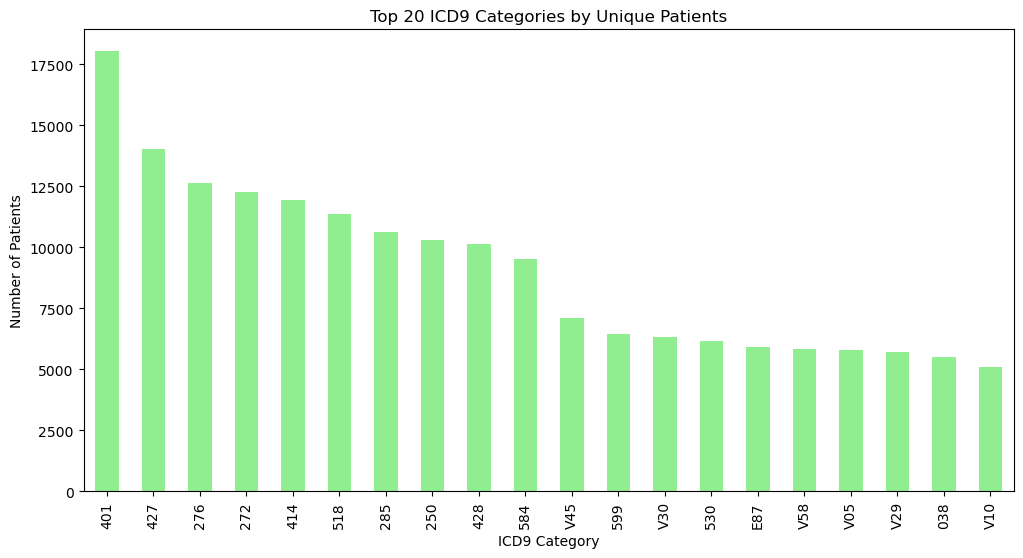

<Figure size 640x480 with 0 Axes>

In [ ]:
diagnoses['ICD9_CATEGORY'] = diagnoses['ICD9_CODE'].astype(str).str[:3]
counts = diagnoses.groupby('ICD9_CATEGORY')['SUBJECT_ID'].nunique().sort_values(ascending=False)

counts.head(20).plot(kind='bar', figsize=(12,6), color=['lightgreen'])
plt.title('Top 20 ICD9 Categories by Unique Patients')
plt.xlabel('ICD9 Category') 
plt.ylabel('Number of Patients')
plt.savefig('../assets/plots/top20_icd9_categories_by_unique_patients.png', dpi=300)
plt.show()

#### 2.3.2 Death Rate Analysis

In the “Highest Death Rate Diagnosis (ICU)” plot, ICD-9 code 038 (Sepsis) exhibits a high mortality rate, surpassed only by codes 486 (Pneumonia) and 410 (Acute Myocardial Infarction). However, each of these alternatives presents specific limitations: Code 486 is marked by significant clinical heterogeneity and high variability in length of stay (LOS), which complicates the development of reliable predictive models. Code 410, despite its clinical severity, is generally associated with shorter and more variable LOS, often driven by rapid outcomes (either recovery or death), limiting the predictive utility of LOS-based models. In contrast, code 038 represents a high-risk condition with a more gradual clinical course and a sufficiently informative LOS distribution. This makes it particularly well-suited for predictive modeling focused on hospital length of stay estimation.

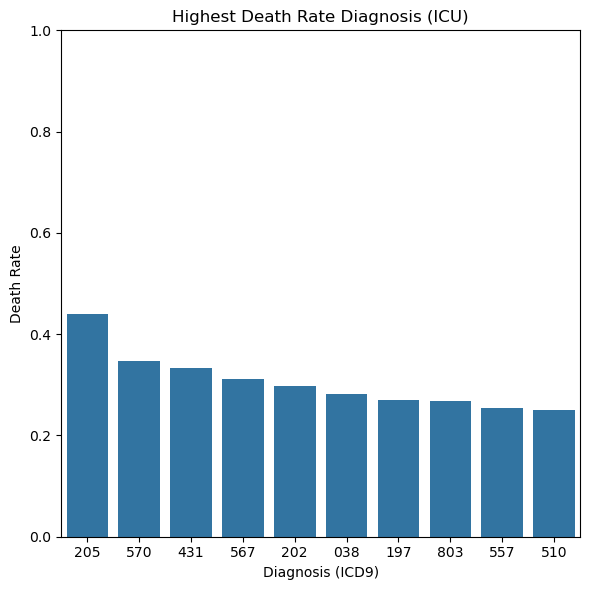

<Figure size 640x480 with 0 Axes>

In [ ]:
main_diag = diagnoses.sort_values('SEQ_NUM').drop_duplicates('HADM_ID', keep='first')
main_diag['ICD9_CODE'] = main_diag['ICD9_CODE'].astype(str).str[:3]

diag_mortality = main_diag.merge(admissions, on='HADM_ID', how='left')

mortality_summary = diag_mortality.groupby('ICD9_CODE').agg(
    N_PATIENTS=('HADM_ID', 'count'),
    N_DEATHS=('HOSPITAL_EXPIRE_FLAG', 'sum')
).reset_index()

mortality_summary['DEATH_RATE'] = mortality_summary['N_DEATHS'] / mortality_summary['N_PATIENTS']

mortality_summary = mortality_summary[mortality_summary['N_PATIENTS'] >= 50] # Filter 
top_mortalità = mortality_summary.sort_values('DEATH_RATE', ascending=False).head(10) # # Sort by death rate

# Plot
plt.figure(figsize=(6, 6))
sns.barplot(data=top_mortalità, x='ICD9_CODE', y='DEATH_RATE')
plt.title('Highest Death Rate Diagnosis (ICU)')
plt.xlabel('Diagnosis (ICD9)')
plt.ylabel('Death Rate')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('../assets/plots/death_rate_by_diagnosis.png', dpi=300)
plt.show()

#### 2.3.3 LOS Analysis
The initial analysis focuses on intensive care unit (ICU) length of stay (LOS) across the most prevalent ICD-9 diagnostic categories and ICU admission diagnoses. Among these, category 038, corresponding to sepsis, stands out due to its moderate-to-high LOS distribution, with a substantial proportion of patients experiencing ICU stays longer than seven days. A particularly noteworthy feature is the relatively low dispersion in LOS for this group, especially when compared to other high-variability critical conditions such as acute respiratory failure (code 518) and acute hepatic failure (code 570). This reduced variability suggests that LOS in septic patients is more stable and predictable, which is a crucial property for the development of reliable predictive models, as it limits unexplained variance and enhances model robustness.

Overall, the findings indicate that septic patients:
* Require considerable intensive care resources;
* Represent a relatively homogeneous population with respect to LOS

This balance between a high median LOS and constrained variability makes sepsis an optimal clinical condition for training and validating predictive models aimed at forecasting ICU stay and optimizing critical care resource allocation.

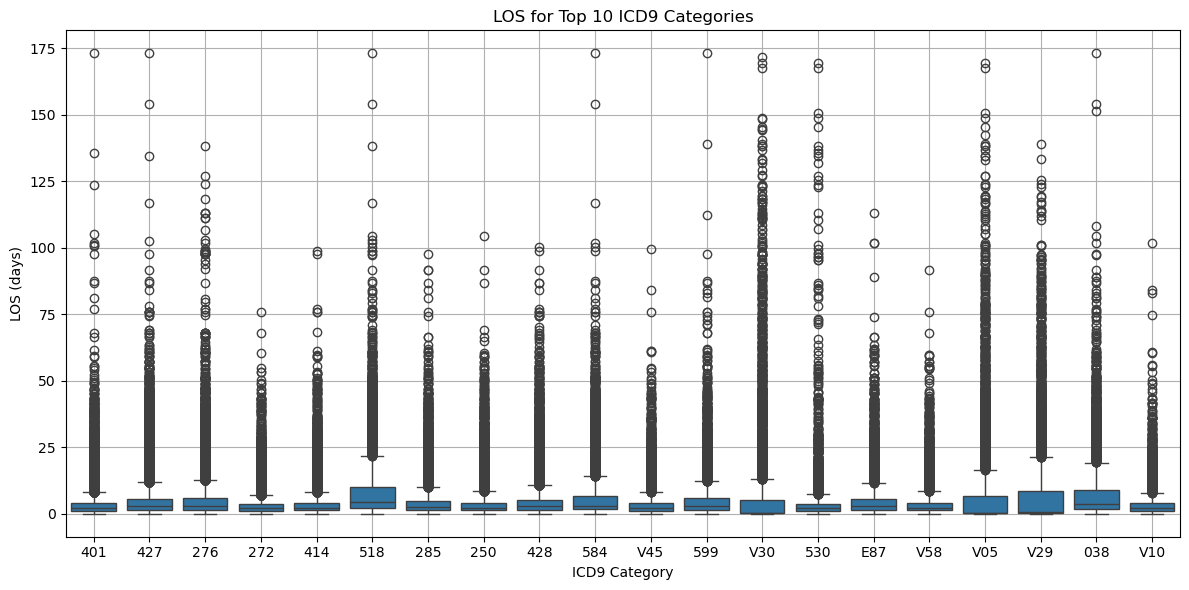

In [29]:
counts = diagnoses.groupby('ICD9_CATEGORY')['SUBJECT_ID'].nunique().sort_values(ascending=False).head(20).index

# Filter
diag_top = diagnoses[diagnoses['ICD9_CATEGORY'].isin(counts)]
diag_top = diag_top.merge(icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS']], on=['SUBJECT_ID', 'HADM_ID'], how='left')
diag_top = diag_top.dropna(subset=['LOS'])

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='ICD9_CATEGORY', y='LOS', data=diag_top, order=counts)
plt.title('LOS for Top 10 ICD9 Categories')
plt.xlabel('ICD9 Category')
plt.ylabel('LOS (days)')
plt.grid(True)
plt.tight_layout()
plt.savefig('../assets/plots/top10_categories_los.png', dpi=300)
plt.show()

#### 2.3.4 Treatments Analysis

Analysis of the drug and antibiotic usage table highlights ICD-9 code 038 (Sepsis) as notable for having one of the highest average numbers of medications administered per patient (~38.6), and an high rate of antibiotic usage (~5.2), second only to code 486.
These indicators reflect a high level of therapeutic intensity and provide a rich source of information - in terms of drug types and dosage patterns - for predictive modeling.
The clinical complexity associated with sepsis appears sufficient to justify advanced analysis of length of stay (LOS).
Conversely, codes 518 and 571 were excluded despite an even greater drug burden, due to their frequent association with multi-organ failure and highly variable interventions, which reduce the reliability and predictive accuracy of modeling efforts.

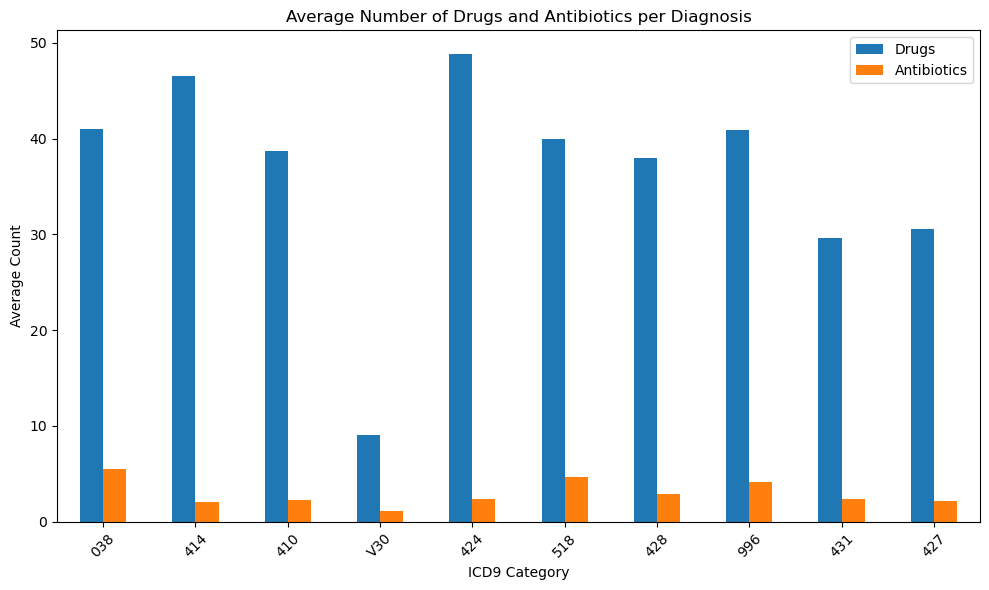

In [31]:
# Antibiotics labels
antibiotic_pattern = 'cillin|mycin|cef|penem|cycline|azole|floxacin'

# Counts drugs per HADM_ID
drug_counts = prescriptions.groupby('HADM_ID')['DRUG'].nunique().reset_index(name='N_DRUGS')

# Counts antibiotics per HADM_ID
abx_mask = prescriptions['DRUG'].str.contains(antibiotic_pattern, case=False, na=False)
abx_counts = prescriptions[abx_mask].groupby('HADM_ID')['DRUG'].nunique().reset_index(name='N_ANTIBIOTICS')

# Merge
drug_data = pd.merge(drug_counts, abx_counts, on='HADM_ID', how='left').fillna(0)

# Add ICD9 Category
main_diagnoses = diagnoses.sort_values('SEQ_NUM').drop_duplicates('HADM_ID', keep='first')
main_diagnoses['ICD9_CATEGORY'] = main_diagnoses['ICD9_CODE'].astype(str).str[:3]

# Add drugs counter
drug_data = pd.merge(drug_data, main_diagnoses[['HADM_ID', 'ICD9_CATEGORY']], on='HADM_ID', how='left')

# Summary
summary = drug_data.groupby('ICD9_CATEGORY').agg({
    'N_DRUGS': 'mean',
    'N_ANTIBIOTICS': 'mean',
    'HADM_ID': 'count'
}).rename(columns={'HADM_ID': 'Patients', 'N_DRUGS': 'Drugs', 'N_ANTIBIOTICS': 'Antibiotics'}).reset_index()

summary = summary.sort_values(by='Patients', ascending=False).head(10)
summary.plot(x='ICD9_CATEGORY', y=['Drugs', 'Antibiotics'], kind='bar', figsize=(10,6))
plt.title('Average Number of Drugs and Antibiotics per Diagnosis')
plt.ylabel('Average Count')
plt.xlabel('ICD9 Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../assets/plots/drug_antibiotic_usage.png', dpi=300)
plt.show()

#### 2.3.5 Final Justification for Selecting ICD-9 Code 038 – Sepsis

The multidimensional analysis of the main ICD-9 diagnoses identifies 038 – Septicemia/Sepsis as the most robust, balanced, and clinically relevant cohort for the task of predicting ICU length of stay (LOS). Unlike other diagnoses that excel in isolated dimensions but fall short in others, code 038 demonstrates a well-rounded profile across all key criteria:

Representativeness: It consistently ranks among the top ten ICD-9 codes in terms of patient volume and ICU admissions, ensuring statistical power without being overly generic or ambiguous, as is the case with code 250 (Diabetes Mellitus).
Clinical Severity: It is associated with high—but not extreme—mortality, indicating a complex and sufficiently prolonged clinical course suitable for predictive modeling (unlike 410 – Acute Myocardial Infarction, which often involves rapid outcomes).
Length of Stay (LOS): It exhibits a relatively long median LOS with low variability, an ideal scenario for building reliable predictive models. In contrast, codes such as 518 or 570 show extreme dispersion, which hinders modeling precision.
Informational Richness: Patients diagnosed with sepsis typically receive numerous medications, including antibiotics, resulting in a structured and informative dataset highly conducive to training machine learning models.
No other ICD-9 category analyzed meets all four criteria with equivalent robustness. Diagnoses like 486 (Pneumonia) or 570 (Liver Failure) offer specific advantages but are limited by structural weaknesses (e.g., clinical heterogeneity, low prevalence, or excessive variability), which undermine their predictive reliability. Therefore, selecting code 038 as the primary cohort allows for an optimal balance between statistical robustness, clinical relevance, and data richness, positioning it as the most suitable candidate for developing effective, generalizable, and clinically meaningful predictive models.

| Criterion                 | 038 – Sepsis         | 250 – Diabetes    | 410 – MI     | 518 – Resp. Failure      |
| ------------------------- | -------------------- | ----------------- | ------------ | ------------------------ |
| Patient Volume            | ✅ High               | ✅ Very High       | ✅ High       | ✅ Moderate               |
| Clinical Severity         | ✅ High               | ⚠️ Low            | ✅ Very High  | ✅ Very High              |
| LOS Stability             | ✅ Moderate & Stable  | ⚠️ Low & Variable | ⚠️ Short LOS | ❌ Very Variable          |
| Treatment Informativeness | ✅ High (drugs & abx) | ⚠️ Low            | ⚠️ Low       | ✅ High but heterogeneous |
| Overall Suitability       | ✅ Optimal            | ❌ Weak context    | ⚠️ Limited   | ❌ Too noisy              |